<a href="https://colab.research.google.com/github/rosafilgueira/Seminar_MUIA/blob/main/Colab/LazyEvaluation_ExecutionPlan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting Google Drive to Colab

# Installing Apache Spark

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 51.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=0b51d56702c2ccc488fb7a733a6b4377fc17b18bbabb1170361f2a8b73f77300
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
!ls

sample_data  spark-3.2.1-bin-hadoop3.2	spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

# Demonstration of lazy evaluation

We create an RDD with one million elements so that the effect of lazy evaluation and caching is significant.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [ ]:
spark

In [ ]:
!ls

sample_data  spark-3.2.1-bin-hadoop3.2	spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
sc = spark.sparkContext
%time RDD=sc.parallelize(range(1000000))



CPU times: user 3.37 ms, sys: 894 µs, total: 4.26 ms
Wall time: 25.2 ms


It takes about 01.-0.5 sec. to create the RDD.

## Define a computation

The role of the function taketime is to consume CPU cycles.

In [ ]:
from math import cos
def taketime(i):
    [cos(j) for j in range(100)]
    return cos(i)

In [ ]:
%time taketime(5)

CPU times: user 56 µs, sys: 11 µs, total: 67 µs
Wall time: 73 µs


0.28366218546322625

## Define the map operation


- Note that this cell takes very little time.
- Because lazy evaluation delays actual computation until needed.


In [ ]:
%time interm=RDD.map(lambda x: taketime(x))

CPU times: user 57 µs, sys: 10 µs, total: 67 µs
Wall time: 74.6 µs



Why did the previous cell took less than 50 micro-seconds (Wall Time)?
- Because no computation was done
- The cell defined an execution plan, but did not execute it yet.



# Execution Plan

At this point the variable Interm does not point to an actual data structure. Instead, it points to an execution plan expressed as a dependence graph. The dependence graph defines the dependence of the RDD on each other.

The dependence graph associated with an RDD can be printed out using the method toDebugString(). The first line corresponds to **interm** and the second line corresponds to **RDD** which is the input to interm


In [ ]:
print(interm.toDebugString())

b'(2) PythonRDD[1] at RDD at PythonRDD.scala:53 []\n |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274 []'


## Define an Action (reduce)

In [ ]:
%time out=interm.reduce(lambda x,y:x+y)
print(out)

CPU times: user 239 ms, sys: 41.7 ms, total: 280 ms
Wall time: 17.4 s
-0.28870546796843666


## Actual execution

The reduce command needs to output an actual output, spark therefor has to actually execute the map and the reduce. Some real computation needs to be done, which takes about 1 - 3 seconds (Wall time) depending on the machine used and on it's load

In [ ]:
print(interm.toDebugString())

b'(2) PythonRDD[1] at RDD at PythonRDD.scala:53 []\n |  ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274 []'


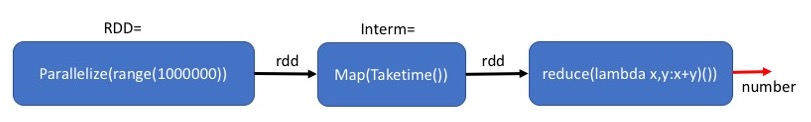


# Executing a different calculation based on the same plan.

The plan defined by Interm can be executed many times. Below we give an example.

Note: the run-time is similar to that of the previous command because the intermediate results that are due to Interm have not been saved in memory.


In [ ]:
%time out=interm.filter(lambda x:x>0).count()
print(out)

CPU times: user 235 ms, sys: 38.2 ms, total: 273 ms
Wall time: 15.5 s
500000


In [ ]:
print(interm.toDebugString())

b'(2) PythonRDD[617] at RDD at PythonRDD.scala:53 []\n |  ParallelCollectionRDD[614] at readRDDFromFile at PythonRDD.scala:274 []'


The middle block: Map(Taketime) is executed twice. Once for each final step.

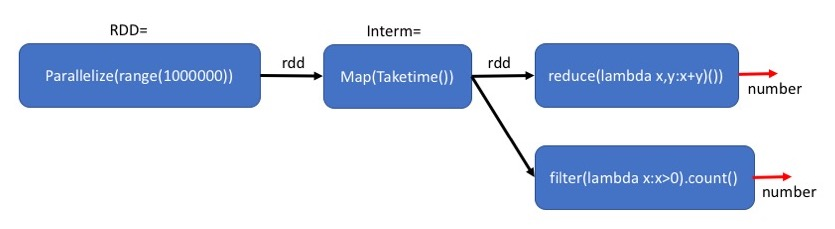

# Caching

The definition of Interm is almost the same as before. However, the plan corresponding to Interm is more elaborate and contains information about how the intermediate results will be cached and replicated.

Note that PythonRDD[XX] is now [Memory Serialized 1x Replicated]

In [ ]:
%time interm=RDD.map(lambda x: taketime(x)).cache()
print (interm.toDebugString())


CPU times: user 11.3 ms, sys: 1.22 ms, total: 12.5 ms
Wall time: 38.6 ms
b'(2) PythonRDD[618] at RDD at PythonRDD.scala:53 [Memory Serialized 1x Replicated]\n |  ParallelCollectionRDD[614] at readRDDFromFile at PythonRDD.scala:274 [Memory Serialized 1x Replicated]'


By adding the Cache after Map(Taketime), we save the results of the map for the second computation.

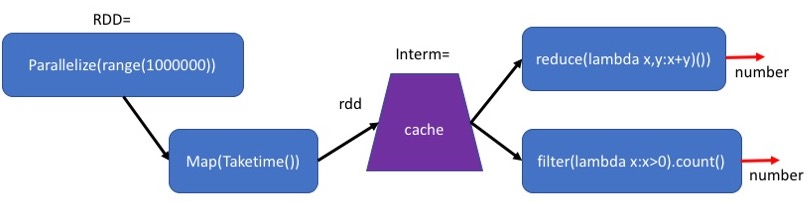

The following command executes the first map-reduce command and caches the result of the map command in memory.

In [ ]:
%time out=interm.reduce(lambda x,y:x+y)
print(out)

CPU times: user 244 ms, sys: 36 ms, total: 280 ms
Wall time: 16.9 s
-0.28870546796843666


# Using the Cache

This time interm is cached. Therefor the second use of interm is much faster than when we did not use cache. 

In [ ]:
%time out=interm.filter(lambda x:x>0).count()
print(out)

CPU times: user 28.6 ms, sys: 2.34 ms, total: 30.9 ms
Wall time: 983 ms
500000
